Train an evidential regression model following the setup from https://arxiv.org/abs/1910.02600.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from probly.losses import EvidentialNIGNLLLoss, EvidentialRegressionRegularization
from probly.representation.regression import Evidential

### Generate synthetic data

In [2]:
def f(x):
    eps = np.random.normal(0, 3, x.shape)
    return x ** 3 + eps
X_train = np.random.uniform(-4, 4, 500)
X_test = np.random.uniform(-6, 6, 250)
X_train = X_train
X_test = X_test
y_train = f(X_train)
y_test = f(X_test)
X_train = torch.from_numpy(X_train).float().view(-1, 1)
X_test = torch.from_numpy(X_test).float().view(-1, 1)
y_train = torch.from_numpy(y_train).float().view(-1, 1)
y_test = torch.from_numpy(y_test).float().view(-1, 1)
train = TensorDataset(X_train, y_train)
test = TensorDataset(X_test, y_test)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

### Define a neural network

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()

### Transform it into an evidential regression model

In [4]:
model = Evidential(net)

### Train the network with the evidential loss and regularization

In [5]:
optimizer = optim.Adam(model.parameters(), 5e-3)
criterion = EvidentialNIGNLLLoss()
regularization = EvidentialRegressionRegularization()
lmbda = 0.01
for epoch in tqdm(range(500)):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets) + lmbda * regularization(outputs, targets)
        loss.backward()
        optimizer.step()

# compute MSE on test set
squared_error = 0
total = 0
model.eval()
for inputs, targets in test_loader:
    outputs = model(inputs)
    squared_error += torch.sum((outputs['gamma'] - targets) ** 2)
    total += targets.size(0)
print(f"MSE: {squared_error / total}")

100%|██████████| 500/500 [00:12<00:00, 39.98it/s]

MSE: 357.46697998046875


### Plot the predictions and the targets

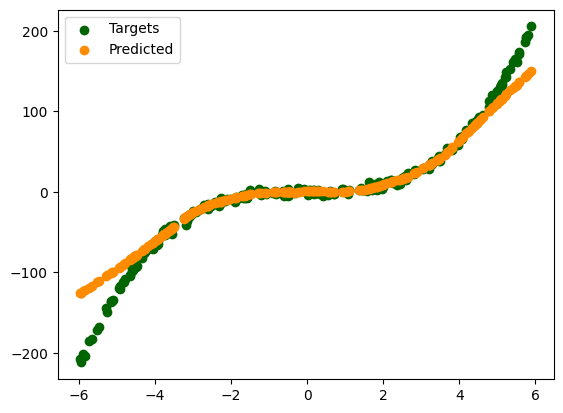

In [6]:
plt.scatter(X_test, y_test, label='Targets', c='darkgreen')
preds = model(X_test)['gamma'].detach().numpy()
plt.scatter(X_test, preds, label='Predicted', c='darkorange')
plt.legend()
plt.show()